In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_score

from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

import sys
import os
sys.path.append("/zhouxibin/workspaces/mutations")
from utils.rank import rank_strategy_dictionary
from utils.model import model_name_library
from utils.pipeline import read_sequence
from utils.metrics import read_dms_file

Matplotlib is building the font cache; this may take a moment.


In [2]:
experimental_TDG_df = pd.read_csv("./12_data/TDG2_exp.csv")
TDG2_df = pd.read_csv("../data/TDG2/TDG2_mutate_one_allsites.csv")
TDG2_finetune_df = pd.read_csv("../data/TDG2/TDG2_650M_finetune_mutate_one_allsites.csv")

In [3]:
TDG2_total_df = pd.merge(TDG2_df, TDG2_finetune_df, on="mut", how="left", suffixes=("_650M", "_650M_finetune"))
TDG2_total_df.head()

,comment_650M,mut,sequence_650M,fitness_650M,comment_650M_finetune,sequence_650M_finetune,fitness_650M_finetune
0,mutations: A147Y probability: 11.3856,A147Y,FFSPSPARKRHAPSPEPAVQGTGVAGVPEESGDAAAIPAKKAPAGQ...,11.385650,mutations: A147Y probability: -0.4089,FFSPSPARKRHAPSPEPAVQGTGVAGVPEESGDAAAIPAKKAPAGQ...,-0.408891
1,mutations: F1M probability: 3.9782,F1M,MFSPSPARKRHAPSPEPAVQGTGVAGVPEESGDAAAIPAKKAPAGQ...,3.978224,mutations: F1M probability: 1.0945,MFSPSPARKRHAPSPEPAVQGTGVAGVPEESGDAAAIPAKKAPAGQ...,1.094533
2,mutations: V274A probability: 3.6236,V274A,FFSPSPARKRHAPSPEPAVQGTGVAGVPEESGDAAAIPAKKAPAGQ...,3.623650,mutations: V274A probability: 1.8411,FFSPSPARKRHAPSPEPAVQGTGVAGVPEESGDAAAIPAKKAPAGQ...,1.841086
3,mutations: H92A probability: 3.2447,H92A,FFSPSPARKRHAPSPEPAVQGTGVAGVPEESGDAAAIPAKKAPAGQ...,3.244741,mutations: H92A probability: 2.2979,FFSPSPARKRHAPSPEPAVQGTGVAGVPEESGDAAAIPAKKAPAGQ...,2.297909
4,mutations: P43R probability: 2.7918,P43R,FFSPSPARKRHAPSPEPAVQGTGVAGVPEESGDAAAIPAKKARAGQ...,2.791762,mutations: P43R probability: -4.8271,FFSPSPARKRHAPSPEPAVQGTGVAGVPEESGDAAAIPAKKARAGQ...,-4.827143


In [4]:
total_df = pd.merge(experimental_TDG_df, TDG2_total_df, on="mut", how="left", suffixes=("_exp", ""))
total_df.head()

,mut,sequence,activity,comment_650M,sequence_650M,fitness_650M,comment_650M_finetune,sequence_650M_finetune,fitness_650M_finetune
0,V274A,FFSPSPARKRHAPSPEPAVQGTGVAGVPEESGDAAAIPAKKAPAGQ...,21.47059,mutations: V274A probability: 3.6236,FFSPSPARKRHAPSPEPAVQGTGVAGVPEESGDAAAIPAKKAPAGQ...,3.623650,mutations: V274A probability: 1.8411,FFSPSPARKRHAPSPEPAVQGTGVAGVPEESGDAAAIPAKKAPAGQ...,1.841086
1,H92A,FFSPSPARKRHAPSPEPAVQGTGVAGVPEESGDAAAIPAKKAPAGQ...,22.20557,mutations: H92A probability: 3.2447,FFSPSPARKRHAPSPEPAVQGTGVAGVPEESGDAAAIPAKKAPAGQ...,3.244741,mutations: H92A probability: 2.2979,FFSPSPARKRHAPSPEPAVQGTGVAGVPEESGDAAAIPAKKAPAGQ...,2.297909
2,P43R,FFSPSPARKRHAPSPEPAVQGTGVAGVPEESGDAAAIPAKKARAGQ...,17.23441,mutations: P43R probability: 2.7918,FFSPSPARKRHAPSPEPAVQGTGVAGVPEESGDAAAIPAKKARAGQ...,2.791762,mutations: P43R probability: -4.8271,FFSPSPARKRHAPSPEPAVQGTGVAGVPEESGDAAAIPAKKARAGQ...,-4.827143
3,I103Q,FFSPSPARKRHAPSPEPAVQGTGVAGVPEESGDAAAIPAKKAPAGQ...,17.67779,mutations: I103Q probability: 2.6124,FFSPSPARKRHAPSPEPAVQGTGVAGVPEESGDAAAIPAKKAPAGQ...,2.612375,mutations: I103Q probability: -3.9884,FFSPSPARKRHAPSPEPAVQGTGVAGVPEESGDAAAIPAKKAPAGQ...,-3.988370
4,P43K,FFSPSPARKRHAPSPEPAVQGTGVAGVPEESGDAAAIPAKKAKAGQ...,18.61282,mutations: P43K probability: 2.2654,FFSPSPARKRHAPSPEPAVQGTGVAGVPEESGDAAAIPAKKAKAGQ...,2.265364,mutations: P43K probability: -4.8424,FFSPSPARKRHAPSPEPAVQGTGVAGVPEESGDAAAIPAKKAKAGQ...,-4.842429


In [5]:
wt_activity = 11.91336
fpr, tpr, threshold = roc_curve(total_df["activity"]>wt_activity, total_df["fitness_650M"])
fpr_finetune, tpr_finetune, threshold_finetune = roc_curve(total_df["activity"]>wt_activity, total_df["fitness_650M_finetune"])
aucroc = auc(fpr, tpr)
aucroc_finetune = auc(fpr_finetune, tpr_finetune)

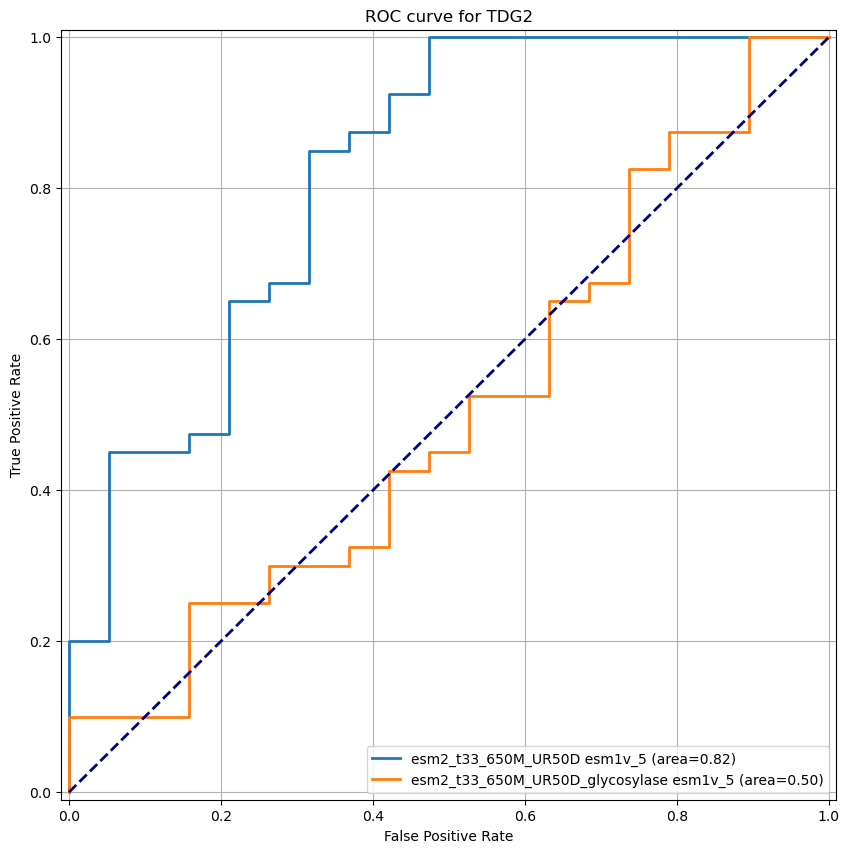

In [6]:
plt.figure(figsize=(10, 10))
lw = 2
plt.plot(fpr, tpr, lw=lw, label=f"esm2_t33_650M_UR50D esm1v_5 (area={aucroc:.2f})")
plt.plot(fpr_finetune, tpr_finetune, lw=lw, label=f"esm2_t33_650M_UR50D_glycosylase esm1v_5 (area={aucroc_finetune:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"ROC curve for TDG2")
plt.legend(loc="lower right")
plt.grid()
plt.savefig("./12_data/TDG2_ROC_650M.png", dpi=600)
plt.savefig("./12_data/TDG2_ROC_650M.tiff", dpi=600)
plt.savefig("./12_data/TDG2_ROC_650M.pdf", dpi=600)

In [8]:
TDG2_rank_df = pd.merge(TDG2_total_df, experimental_TDG_df, on="mut", how="left", suffixes=("_650M", "_exp"))
TDG2_rank_df = TDG2_rank_df.sort_values(by="fitness_650M", ascending=False).reset_index()
TDG2_ranks = list(TDG2_rank_df.index[TDG2_rank_df["activity"] > wt_activity])
TDG2_rank_df_finetune = TDG2_rank_df.sort_values(by="fitness_650M_finetune", ascending=False).reset_index()
TDG2_ranks_finetune = list(TDG2_rank_df_finetune.index[TDG2_rank_df_finetune["activity"] > wt_activity])
len(TDG2_ranks), len(TDG2_ranks_finetune)

(40, 40)

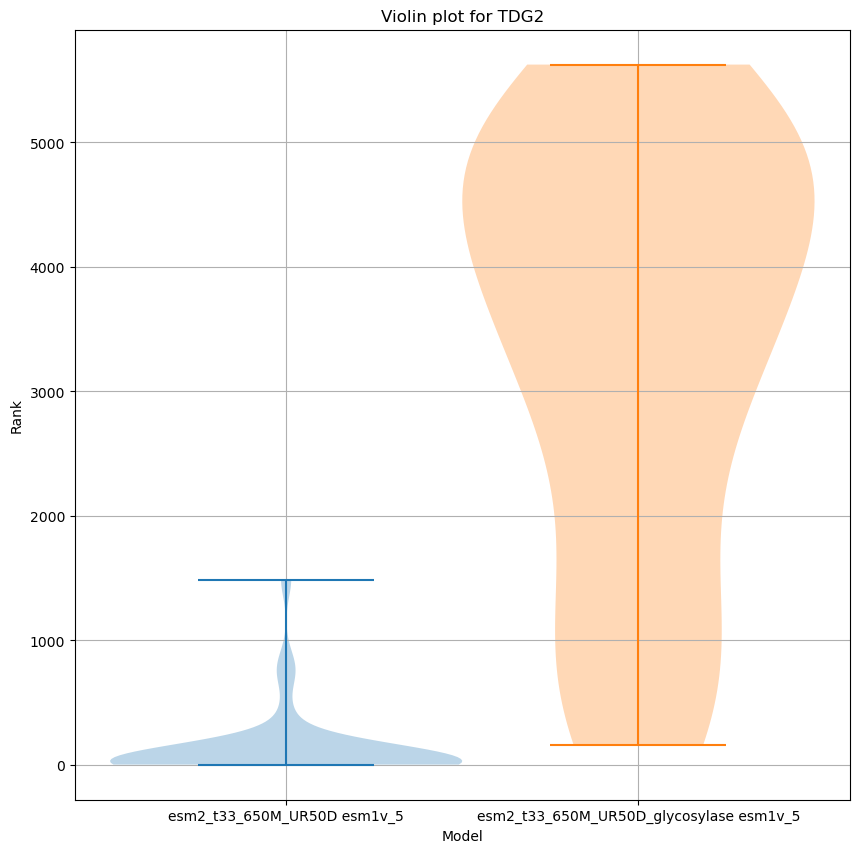

In [15]:
plt.figure(figsize=(10, 10))
plt.violinplot(TDG2_ranks,
                positions=[0],
                showextrema=True,
                # quantiles=[[0.25, 0.5, 0.75]],
                widths=0.2,
        ) 
plt.violinplot(TDG2_ranks_finetune,
                positions=[0.2],
                showextrema=True,
                # quantiles=[[0.25, 0.5, 0.75]],
                widths=0.2
        ) 
plt.xlabel("Model")
plt.ylabel("Rank")
plt.title("Violin plot for TDG2")
plt.grid()
plt.xticks([0, 0.2], ["esm2_t33_650M_UR50D esm1v_5", "esm2_t33_650M_UR50D_glycosylase esm1v_5"])
plt.savefig("./12_data/TDG2_violin_650M.png", dpi=600)
plt.savefig("./12_data/TDG2_violin_650M.tiff", dpi=600)
plt.savefig("./12_data/TDG2_violin_650M.pdf", dpi=600)